# EFA from GEFS

This uses the efa_xray package (https://github.com/lmadaus/efa_xray.git), specifically the simple_gefs branch, to grab the "latest" GEFS ensemble forecast and update it with the most recent observations as they become available.

In [1]:
# Some initial imports of libraries we will use
from __future__ import print_function, division
import cPickle
import numpy as np
from datetime import datetime, timedelta
from mpl_toolkits.basemap import Basemap
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

/home/disk/aleutians/nobackup/lmadaus/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Building the state

The function below uses the Siphon libraries (https://github.com/Unidata/siphon) to download the requested subset of the latest GEFS ensemble.  Specifically, you give the function a list of the state variables you want and optionally the lat/lon bounds of a geographical area you want and it will download the corresponding GEFS forecast and format into an efa_xray ensemble state object.

In [2]:
def state_from_gfse(statevars=['t2'], bounds=None):
    """ 
    Build an xray state vector from GEFS forecasts 
    
    Requires:
    statevars -> A list of state variables to collect.  These must appear as keys 
                 in the "vardict" dictionary within this function.
    bounds    -> A 4-member tuple of bounding lats and lons: (West, East, South, North)
                 If this is None (default), will download entire spatial domain of ensemble
   
    
    Returns:
    An ensemble state object
    ny -> Number of Y points in original state
    nx -> Number of X points in original state
    
    
    """
    # Import the following items.  The siphon_gefs script is specific
    # to the simple_gefs branch of code
    from efa_xray.ensemble_class import Xray_Ensemble_State
    from netCDF4 import Dataset, num2date
    from datetime import datetime, timedelta
    from numpy import reshape, zeros
    import os
    from siphon_gfse import get_gefs_ensemble
    
    
    # Here we have a dictionary translatingsome generic names 
    # for possible state vector variables and translating to
    # what they correspond to in the raw GEFS files
    vardict = {'t2' : 'Temperature_height_above_ground_ens',
               'slp' : 'Pressure_reduced_to_MSL_msl_ens',
               'psfc' : 'Pressure_surface_ens',
               }
    
    # Get the data from Unidata/Siphon
    # This returns a netcdf-like object
    raw_ensemble = get_gefs_ensemble([vardict[x] for x in statevars], bounds=bounds, writeout=False)
 

    
    # Now build the metadata to describe this ensemble
    # Create an empty dictionary to hold metadata
    meta = {}
    
    # Sometimes the time variable in the GEFS is listed as "time2"
    # and at other times it's just "time".  Check to see what we
    # have here
    if 'time' in raw_ensemble.dimensions.keys():
        timevar = 'time'
    elif 'time1' in raw_ensemble.dimensions.keys():
        timevar = 'time1'
    elif 'time2' in raw_ensemble.dimensions.keys():
        timevar = 'time2'
    else:
        print("Unable to find a time dimension in GEFS raw ensemble.")
        return None
    
    
    # Get the dimensions of the state
    nmems = len(raw_ensemble.dimensions['ens'])
    ntimes = len(raw_ensemble.dimensions[timevar])
    ny = len(raw_ensemble.dimensions['lat'])
    nx = len(raw_ensemble.dimensions['lon'])
    nvars = len(statevars)
    
    # Total number of geographic locations
    nlocs = ny*nx
    
    # Allocate an empty array to hold the entire state vector
    print("Allocating the state vector array...")
    state = zeros((nvars, ntimes, nlocs, nmems))
    
    # For metadata, need list of times and locations
    # Use num2date to convert to datetime objects
    times = raw_ensemble.variables[timevar]
    valid_times = num2date(times[:], times.units)
    
    # Locations will be flattened out into a single dimension
    # Location is every latitude and longitude in the flattened array
    # First, need to expand the 1d latitude array into a full 2d
    # array so we have latitude at each grid point
    latl = np.array(raw_ensemble.variables['lat'][:])[:,None]*np.ones((ny,nx))
    # Then flatten this 2d array to a 1d array
    lats = list(latl.flatten())
    
    # Now do the same for the longitudes
    lonl = np.array(raw_ensemble.variables['lon'][:])[None,:]*np.ones((ny,nx))
    lons = list(lonl.flatten())
    # Convert to negative lons
    lons = [l-360.0 if l > 180.0 else l for l in lons]
    
    # Zip the latitudes and longitudes together.  This gives a lat-lon pair
    # for each point.
    locations = zip(lats,lons)
    # Xray doesn't like tuples as coordinates, so need to make these strings
    locations = ['{:7.4f},{:7.4f}'.format(l[0],l[1]) for l in locations]

    # Compose the metadata
    print("Building state metadata...")
    meta[(0,'var')] = statevars
    meta[(1,'time')] = valid_times
    meta[(2,'location')] = locations
    meta[(3,'mem')] = [n+1 for n in xrange(nmems)]
    # metadata is now done
    
    
    # Now we can populate the state array
    # Loop through each state variable requested
    # and insert it into the empty array we allocated earlier
    for var in statevars:
        # Squeeze this variable to remove any singleton dimensions
        field = np.squeeze(raw_ensemble.variables[vardict[var]][:])
        # For surface pressure fields, put it in hPa
        if var in ['prmsl','psfc']:
            field = field / 100.
        # Reshape this to be flattened in space (so it matches the location metadata)
        field = np.reshape(field,(ntimes,nmems,ny*nx))
        # Swap the last two axes so members dimension is last
        # This makes most operations faster
        field = np.swapaxes(field,1,2)
        # Put this variable into the state array
        state[statevars.index(var),:,:,:] = field
    
    # The following block of code is an example of reading the state
    # from multiple existing netcdf files (one per member) instead of
    # using siphon
    """
    for mnum, mem in enumerate(memfiles):
        # Point to the file
        data = Dataset('/'.join((filedir,mem)),'r')
        # If this is the first member, calculate how large the state
        # array needs to be and allocate.  Also set up the metadata.
        if mnum == 0:
            nmems = len(memfiles)
            ntimes = len(data.dimensions['time'])
            nvars = len(statevars)
            ny = len(data.dimensions['latitude'])
            n3x = len(data.dimensions['longitude'])
            nlocs = ny * nx
            # Allocate the state array
            print("Allocating the state vector array...")
            state = zeros((nvars,ntimes,nlocs,nmems))
            
            # For the metadata, need a list of times and locations
            ftimes = [datetime(1970,1,1) + timedelta(seconds=d) for d in data.variables['time'][:]]
            # Location is every latitude and longitude in the flattened array
            latl = np.array(data.variables['latitude'][:])[:,None]*np.ones((ny,nx))
            lats = list(latl.flatten())
            
            lonl = np.array(data.variables['longitude'][:])[None,:]*np.ones((ny,nx))
            lons = list(lonl.flatten())
            # Convert to negative lons
            lons = [l-360.0 if l > 180.0 else l for l in lons]
            # Zip these
            locations = zip(lats,lons)
            locations = ['{:3.4f},{:3.4f}'.format(l[0],l[1]) for l in locations]
            
            # Compose the metadata
            print("Building state metadata...")
            meta[(0,'var')] = statevars
            meta[(1,'time')] = ftimes
            meta[(2,'location')] = locations
            meta[(3,'mem')] = [n+1 for n in xrange(nmems)]
        
        # Now we can populate the state array
        for var in statevars:
            field = data.variables[vardict[var]][:]
            if var in ['prmsl','psfc']:
                field = field / 100.
            # Reshape this to be flattened in space
            field = reshape(field,(ntimes,ny*nx))
            # Populate its component of the state array
            state[statevars.index(var),:,:,mnum] = field
        data.close()
    """
    # Some cleanup
    # Free up the memory held by the raw_ensemble object
    del raw_ensemble
    
    # Print out the ensemble shape
    print("State dimension sizes:")
    for name,dat in meta.items():
        print(name,len(dat))
    # Package this into an Xray_EnsembleSstate object knowing the state and metadata
    statecls = Xray_Ensemble_State(state=state, meta=meta)
    return statecls, ny, nx


What is an Xray_Ensemble_State object? It uses the xray libraries (http://xray.readthedocs.org/en/stable/) to package the state as a multi-dimensional array and facilitate more intuitively accessing specific parts of that array.  It also adds several methods that can work on the state object to perform common tasks in ensemble data assimilation.  We can look at a list of these methods below:

In [3]:
from efa_xray.ensemble_class import Xray_Ensemble_State
help(Xray_Ensemble_State)

Help on class Xray_Ensemble_State in module efa_xray.ensemble_class:

class Xray_Ensemble_State
 |  Define an ensemble state vector
 |  
 |  Methods defined here:
 |  
 |  __init__(self, state=None, meta=None, usevars=None, usedims=None)
 |      Initialize based on the input.  We are either given a
 |      netCDF4 "Dataset" object as "state" with a list of variables and dimensions
 |      to use OR we are given a numpy ndarray as a state with the variables and
 |      dimensions specified in the variable "meta"
 |  
 |  chunk_bounds(self, nChunks)
 |      Function to compute the bounding array locations when dividing up a
 |      state array.  Returns a dictionary.
 |  
 |  ensemble_mean(self)
 |      Returns the ensemble mean of the state as a DataArray
 |  
 |  ensemble_perts(self)
 |      Removes the ensemble mean and returns an Xray DataArray        of the perturbations from the ensemble mean
 |  
 |  ensemble_times(self)
 |      Return the values of the time dimension AS DATETIME 

Let's actually build a state using the latest GEFS forecast.  We do that below.

In [4]:
# Create a list of state variables.  Here let's just grab 2m temperature
statevars = ['t2']
# Only focus on CONUS--these are W,E,S,N lon-lat bounds
bounds=(-124.9,-66.8,24.3,49.4)
# For now, we are going to have observations of the same variables
# as in the state (instead of a subset)
obtypes = statevars

# Download the latest GFSE ensemble and package it into an Xray_Ensemble_State object
# using the above function
state_vect, ny, nx = state_from_gfse(statevars=statevars, bounds=bounds)

# We can use the methods of this object to tell us about our state
ftimes = state_vect.ensemble_times()
print("Forecast times in state:", ftimes)


<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Originating_or_generating_Center: US National Weather Service, National Centres for Environmental Prediction (NCEP)
    Originating_or_generating_Subcenter: NCEP Ensemble Products
    GRIB_table_version: 2,1
    Type_of_generating_process: Ensemble forecast
    Analysis_or_forecast_generating_process_identifier_defined_by_originating_centre: Global Ensemble Forecast System (GEFS)
    Conventions: CF-1.6
    history: Read using CDM IOSP GribCollection v3
    featureType: GRID
    History: Translated to CF-1.0 Conventions by Netcdf-Java CDM (CFGridWriter2)
Original Dataset = /data/ldm/pub/native/grid/NCEP/GEFS/Global_1p0deg_Ensemble/member/GEFS_Global_1p0deg_Ensemble_20160427_1200.grib2.ncx3#LatLon_181X360-p5S-180p0E; Translation Date = 2016-04-27T21:22:33.455Z
    geospatial_lat_min: 24.0
    geospatial_lat_max: 49.0
    geospatial_lon_min: -125.0
    geospatial_lon_max: -67.0
    dimensi

# Getting Observations

There is a siphon utility for getting observations.  The only problem is the observations on siphon seem to be out of date (they are several days behind).  So we are going to use a clunky function that parses data from locally-stored files at the UW and returns a list of Observation objects from the metar observations at times that overlap with our ensemble state times.

In [5]:
from mesowest_observations import get_mesowest_obs

What's in an Observation object? We can look at its methods with the help function like we did with the Xray_Ensemble_State class.  The Observation object also stores the value, type, time, error, and location values for the ob.

In [6]:
from efa_xray.observation_class import Observation
help(Observation)

Help on class Observation in module efa_xray.observation_class:

class Observation
 |  Methods defined here:
 |  
 |  H(self, state)
 |      Given an ensemble state class, compute an H
 |  
 |  H_Xb(self, state)
 |      Return the ensemble (state) estimate of the ob
 |  
 |  __init__(self, value=None, obtype=None, time=None, error=None, location=None, prior_mean=None, post_mean=None, prior_var=None, post_var=None, assimilate_this=False, description=None, localize_radius=None)
 |  
 |  distance_to_state(self, state)
 |      Return the distance from this ob to all locations in the state
 |      vector (in km)
 |  
 |  localize(self, state, type='GC', full_state=False)
 |      Given a state vector object, assume location is in lat/lon and compute a
 |      Gaspari-Cohn weighting function with the specified halfwidth (in km)
 |  
 |  map_localization(self, state, m, ny, nx, type='GC')
 |      Function to map localization radius 
 |      Requires:
 |          state --> The state vector we a

We're going to use that clunky function above to get the METAR observations that overlap with our ensemble times.

In [7]:
# Now we grab the observations.  Note we've specified the sites we want in siteids,
# the observation types we want in obtypes (which is the same as statevars, here t2),
# and the times to get in "use_times" (which is the same as the times in the ensemble)
observations = []
for time in ftimes:
    if time <= datetime.utcnow():
        newobs = get_mesowest_obs(time, bounds=bounds, vars=statevars)
        observations += newobs
print('Number of obs found:', len(observations))

Number of obs found: 1296


# Setting up the assimilation

Now we have an Xray_Ensemble_State and a list of observation objects. There are a few fun methods build into the observations and the ensemble state classes we can leverage.  Let's first define a background map we can plot on.

In [8]:
# This builds a python basemap object of a mercator projection
# using the lat-lon bounds of our domain

m = Basemap(projection='merc', resolution = 'l',\
            llcrnrlon=bounds[0], urcrnrlon=bounds[1],
            llcrnrlat=bounds[2], urcrnrlat=bounds[3])

There's a built-in method to look at how localization works.  Each Observation object as a "map_localization" method, where you can feed the observation a state vector, a map to plot on, and the 2-d dimensions of the map (ny and nx from before) and it will make a map of localization weights.

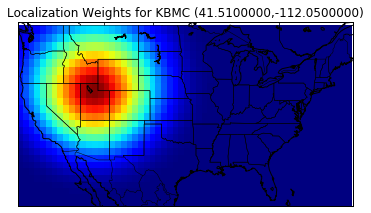

In [9]:
# This grabs the observation at location [1] in the list and plots its localization weights
observations[1].map_localization(state_vect, m, ny, nx)

You can change individual facets for each observation.  For instance, the default localization radius is 1000km.  You could change this ob's localization radius to something like 2000 km...

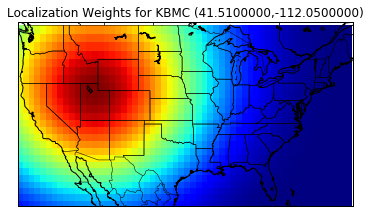

In [10]:
observations[1].localize_radius = 2000.0
observations[1].map_localization(state_vect, m, ny, nx)

By default, each observation has an attribute "assimilate_this" that needs to be set to True for the enkf to assimilate the ob.  We can loop through the observations and set this.

In [11]:
# We'll put the localization radius for that ob back where it was
observations[1].localize_radius = 1000.0
# Loop through the observations
for ob in observations:
    # Make all obs False
    ob.assimilate_this = False
    # However, if the ob's time is between 12Z and 18Z, assimilate it
    if (ob.time.hour <= 18) and (ob.time.hour >= 12):
        ob.assimilate_this = True

# Assimilation

We have the obs, we have the state, we can now assimilate them.  Import the enkf_update utility and use the "update" method to do the update.

In [13]:
# Import the enkf_update method
import efa_xray.enkf_update
reload(efa_xray.enkf_update)

# We feed the enkf the state_vect and observations, specify localization to be Gaspari-Cohn (GC)
# At this point, LEAVE NPROC SET TO 1.  This is supposed to allow you to do multiprocessing in the
# future, but it doesn't work quite right yet.
# The function returns a posterior state and observations
# The posterior state is another Xray_Ensemble_State object
post_state, post_obs = efa_xray.enkf_update.update(state_vect, observations, loc='GC', nproc=1)

Here we're just going to loop through a subset of the observations and print statistics about the assimilation

In [14]:
for ob in observations[0:100:10]:
    prior_mean = np.mean(ob.H_Xb(state_vect))
    post_mean = np.mean(ob.H_Xb(post_state))
    prior_error = abs(prior_mean - ob.value)
    post_error = abs(post_mean - ob.value)
    print(ob.description, ob.time, ob.obtype, ob.value, prior_mean, ob.assimilated, post_mean, post_error - prior_error)

KSLC 2016-04-27 12:00:00 t2 280.95 276.975948645 True 277.917296211 -0.941347566081
KBHK 2016-04-27 12:00:00 t2 274.25 274.924370031 True 274.201003733 -0.62537376351
KCOD 2016-04-27 12:00:00 t2 272.15 269.48506851 True 271.335569624 -1.85050111441
KEKO 2016-04-27 12:00:00 t2 274.25 274.218823048 True 275.099029597 0.817852644341
KGUP 2016-04-27 12:00:00 t2 274.25 274.952613929 True 275.169534416 0.216920487048
KLKV 2016-04-27 12:00:00 t2 277.15 273.614958463 True 275.683193542 -2.06823507868
KMYF 2016-04-27 12:00:00 t2 285.35 282.983347863 True 283.023927578 -0.0405797142919
KPDT 2016-04-27 12:00:00 t2 282.05 280.42081332 True 280.851744578 -0.43093125781
KROW 2016-04-27 12:00:00 t2 278.75 283.15278083 True 282.572528579 -0.580252251269
KSMF 2016-04-27 12:00:00 t2 283.15 280.654786464 True 281.855129907 -1.20034344314


And here we're going to plot the increments to the forecast at a variety of times

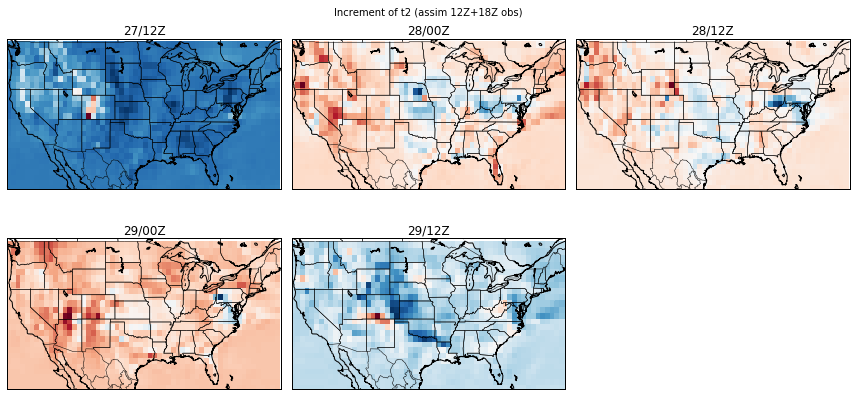

In [16]:
# We're going to plot every other time in the forecast (every 12 hours)
timelist = ftimes[::2]
# Figure out how many panels we need for our figure
ntimes = len(timelist)
nrows = ntimes / 2 + 1
pltvar = 't2'
# Make the plot
plt.figure(figsize=(12,6))
# Loop through each time we identified above
for tnum, t in enumerate(timelist):
    # New subplot
    plt.subplot(2,nrows,tnum+1)
    # This line takes the ensemble mean from the entire prior state and finds all values where
    # the time is equal to this time and the variable t2.  The ability to do
    # this in one line is why we use the Xray libraries
    prior_mean = state_vect.ensemble_mean().loc[dict(time=t,var=pltvar)].values
    # Same for the posterior (updated) state
    post_mean = post_state.ensemble_mean().loc[dict(time=t,var=pltvar)].values
    
    # Remember way back at the beginning our locations got flattened out into
    # 1d arrays.  Here we reshape them to 2d arrays again.
    prior_mean = np.reshape(prior_mean,(ny,nx))
    post_mean = np.reshape(post_mean, (ny,nx))
    # Compute the increment by subtracting the updated mean from the prior mean
    increment = np.subtract(post_mean, prior_mean)
    # Use our baemap object to project into plotting coordinates
    x,y = state_vect.project_coordinates(m,ny,nx)
    # Plot the map
    incplot = plt.pcolormesh(x,y,increment,cmap = matplotlib.cm.RdBu_r)
    # Draw the coastlines and boundaries
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    # Title is the valid date
    plt.title(t.strftime('%d/%HZ'))
    #if tnum == 0:
    #    plt.colorbar(incplot)
# This makes a master title
plt.suptitle('Increment of {:s} (assim 12Z+18Z obs)'.format(pltvar))
# Cleans up the plot
plt.tight_layout()
plt.show()
